In [1]:
import json
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import numpy as np
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statannotations.Annotator import Annotator


In [2]:
def cv_evaluate(features: pd.DataFrame, labels: pd.DataFrame, params: dict, scoring="roc_auc", random_state=1):
    n_repeats = 5
    n_splits = 5
    n_jobs = -1

    rkf = RepeatedStratifiedKFold(n_repeats=n_repeats, n_splits=n_splits, random_state=random_state)

    pipe = Pipeline(
        [('var_thresh', VarianceThreshold()),
         ('scaler', StandardScaler()),
         ('imputer', KNNImputer()),
         ('sampler', RandomUnderSampler(random_state=random_state)),
         ('clf', BalancedRandomForestClassifier(random_state=random_state, n_jobs=n_jobs, sampling_strategy='all',
                                                replacement=True))])

    pipe.set_params(**params)

    X, X_test, y, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, stratify=labels,
                                            random_state=random_state)

    rs_result = cross_validate(pipe, X, y, cv=rkf, scoring=scoring, n_jobs=n_jobs)
    rs_results_cv = pd.DataFrame(rs_result)

    model = pipe.fit(X, y)

    return rs_results_cv, model, X, y, X_test, y_test


network_type = 'large'
target_db = 'DRH'

scoring = 'roc_auc'
random_state = 231222


In [4]:
outcomes = ['No-Effect vs. Effect', 'No-Effect vs. Cyto', 'Cyto vs. Effect']
results = {}
results_random = {}
for outcome in outcomes:
    print(" " + outcome)
    rand_cv_results = []
    for i in range(0, 50):
        print(i)
        original = pd.read_csv(f'../../2_feature_extraction/{network_type}/rand_{i}_features_{target_db} Target.csv', index_col=0)
        original = original.drop(['Target', 'Neighbor'], axis=1)
        original = original[original['Outcome'] != 'Very Weak']
        original = original[original['Outcome'] != 'Low']
        original['Outcome'] = original['Outcome'].replace({'Weak': 'Effect'})
        original['Outcome'] = original['Outcome'].replace({'Strong': 'Effect'})
        original['Outcome'] = original['Outcome'].replace({'No-Effect': 0, 'Cyto': -1, 'Effect': 1})
        data = original.copy()
        os = outcome.split(' vs. ')
        drop_outcome = None
        if 'Effect' not in os:
            drop_outcome = 1
            data = data[data['Outcome'] != drop_outcome]
            data['Outcome'] = data['Outcome'].replace({-1: 1})
        elif 'Cyto' not in os:
            drop_outcome = -1
            data = data[data['Outcome'] != drop_outcome]
        elif 'No-Effect' not in os:
            drop_outcome = 0
            data = data[data['Outcome'] != drop_outcome]
            data['Outcome'] = data['Outcome'].replace({-1: 0})
        else:
            raise Exception()
    
        data = data.dropna()
        labels = data.copy().loc[:, 'Outcome']
        features = data.copy().drop('Outcome', axis=1)
        with open(f'../../4_hyperparameter_search/{network_type}/{outcome.replace("_", "-").replace(" vs. ", "_")}.json',
              'r') as file:
            real_params = json.load(file)
        cv_result, _, _, _, _, _ = cv_evaluate(features, labels, params=real_params, scoring=scoring)
        rand_cv_results.append(cv_result['test_score'].mean())
    results_random[outcome] = {'cv_evaluation': rand_cv_results, 'model': None}
 
joblib.dump(results_random, f'results_rand_net.sav')

 No-Effect vs. Effect
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
 No-Effect vs. Cyto
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
 Cyto vs. Effect
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


['results_rand_net.sav']

In [5]:
model_evaluations = []

In [6]:
target_results = joblib.load(f'../large/results_new.sav')

In [7]:
results = target_results['real']
for key in results.keys():
    result = results[key]['cv_evaluation'].loc[:, 'test_score'].to_frame()
    result['model'] = key
    result['labels'] = 'real'
    result['metric'] = scoring
    result.columns = ['score', 'model', 'labels', 'metric']
    model_evaluations.append(result)

In [8]:
results_random = target_results['random']
for key in results.keys():
    result_random = results_random[key]['cv_evaluation']
    result_random = pd.concat(result_random).reset_index()
    result_random = result_random.loc[:, 'test_score'].to_frame()
    result_random['iter'] = (result_random.index // 25) + 1
    result_random = result_random.groupby('iter').mean()
    result_random['model'] = key
    result_random['labels'] = 'randomly scrambled labels'
    result_random['metric'] = scoring
    result_random.columns = ['score', 'model', 'labels', 'metric']
    model_evaluations.append(result_random)

In [9]:
target_results = joblib.load(f'results_rand_net.sav')

results = target_results.copy()
for key in results.keys():
    result = pd.DataFrame(results[key])
    result['model'] = key
    result['labels'] = 'randomly connected network'
    result['metric'] = scoring
    result.columns = ['score', 'model', 'labels', 'metric']
    model_evaluations.append(result)

,score,model,labels,metric
0,0.751767,No-Effect vs. Effect,real,roc_auc
1,0.739690,No-Effect vs. Effect,real,roc_auc
2,0.695208,No-Effect vs. Effect,real,roc_auc
3,0.671569,No-Effect vs. Effect,real,roc_auc
4,0.683178,No-Effect vs. Effect,real,roc_auc
...,...,...,...,...
45,0.663439,Cyto vs. Effect,randomly connected network,roc_auc
46,0.720852,Cyto vs. Effect,randomly connected network,roc_auc
47,0.676507,Cyto vs. Effect,randomly connected network,roc_auc
48,0.664122,Cyto vs. Effect,randomly connected network,roc_auc


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


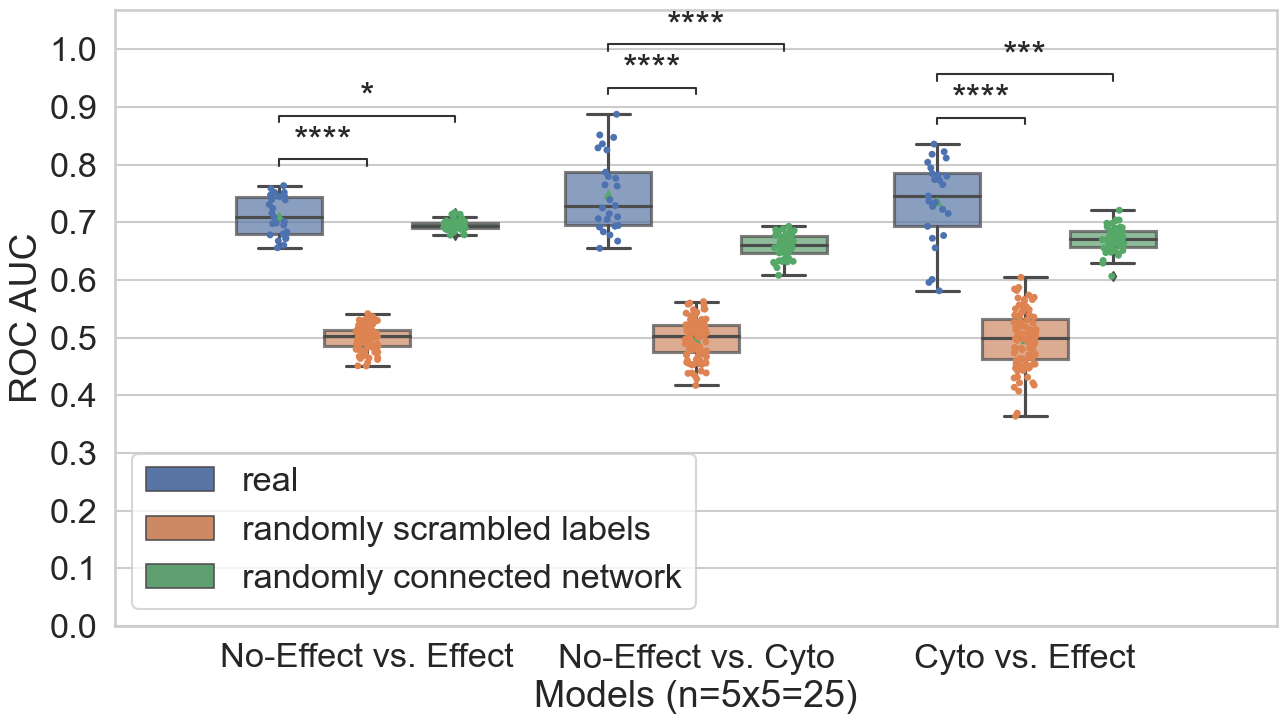

In [10]:
scores = pd.concat(model_evaluations)
display(scores)

sns.set("talk", font_scale=1.5)
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(15, 8), dpi=100)
sns.boxplot(data=scores, x='model', y='score', hue='labels', showmeans=True, ax=ax, boxprops=dict(alpha=.7))
sns.stripplot(data=scores, x='model', y='score', hue='labels', ax=ax, dodge=True, jitter=True, alpha=1.0)
pairs = [(('No-Effect vs. Cyto', 'real'), ('No-Effect vs. Cyto', 'randomly scrambled labels')),
         (('No-Effect vs. Effect', 'real'), ('No-Effect vs. Effect', 'randomly scrambled labels')),
         (('Cyto vs. Effect', 'real'), ('Cyto vs. Effect', 'randomly scrambled labels')),
         (('No-Effect vs. Cyto', 'real'), ('No-Effect vs. Cyto', 'randomly connected network')),
         (('No-Effect vs. Effect', 'real'), ('No-Effect vs. Effect', 'randomly connected network')),
         (('Cyto vs. Effect', 'real'), ('Cyto vs. Effect', 'randomly connected network'))]
annotator = Annotator(ax, pairs, data=scores, x="model", y="score", hue="labels")
annotator.configure(test='t-test_welch', text_format='star', loc='inside', verbose=0, text_offset=0,
                    line_offset=0.0)
annotator.apply_and_annotate()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:3], labels[:3])
ax.set(ylabel='ROC AUC')
ax.set(xlabel='Models (n=5x5=25)')
ax.set(yticks=np.arange(0.0, 1.1, step=0.1))
fig.savefig(f'cv_evaluation.png', format="png", dpi=300)
fig.savefig(f'cv_evaluation.pdf', format="pdf", dpi=300)